In [55]:
import pandas as pd 
import os
import numpy as np
from skimage.io import imread
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import Xception, EfficientNetB0
import pickle
import matplotlib.pyplot as plt 
import seaborn as sns
import random

In [56]:
def prepareDataNN(df):
    data = []
    labels = []
    df_filtered = pd.DataFrame(columns=["patch_filename", "plastic"])
    patches_path = '/home/giorgia/Desktop/MAI/Thesis/images/patches/'
    for i in range(len(df)):
        patch_filename = os.path.join(patches_path, os.path.basename(df.loc[i, 'patch_filename']))
        im = imread(patch_filename)
        if im.shape == (256, 256, 3):
            data.append(im)
            labels.append(np.array(df.loc[i, 'plastic']))
            df_filtered = df_filtered.append(pd.Series(data={"patch_filename":df.loc[i, 'patch_filename'], "plastic":df.loc[i, 'plastic']}), ignore_index=True)
    return data, labels, df_filtered

In [57]:
def prepareData(df):
    data = []
    labels = []
    patches_path = '/home/giorgia/Desktop/MAI/Thesis/images/patches/'
    for i in range(len(df)):
        patch_filename = os.path.join(patches_path, os.path.basename(df.loc[i, 'patch_filename']))
        #im = np.amax(imread(patch_filename), axis=2) # maximum intensity projection
        im = imread(patch_filename)
        if im.shape == (256, 256, 3):
            feat, _ = np.histogram(im, bins = 100)
            data.append(feat)
            labels.append(df.loc[i, 'plastic'])
    return data, labels

In [58]:
df = pd.read_csv('/home/giorgia/Desktop/MAI/Thesis/patch_info.csv')
len(df[df.plastic!=-1])
df = pd.read_csv('/home/giorgia/Desktop/MAI/Thesis/patch_info.csv')
df = df[df.plastic!=-1]
_,_,df = prepareDataNN(df) # filter patches of size < 256 * 256

df_plastic = df[df.plastic==1].reset_index()
df_noplastic = df[df.plastic==0].reset_index()
len(df_plastic), len(df_noplastic)

(583, 575)

In [59]:
partition = 0.85

rand_ind_p = random.sample(range(0, len(df_plastic)), int(partition*len(df_plastic)))
rand_ind_np = random.sample(range(0, len(df_noplastic)), int(partition*len(df_noplastic)))

training_set = pd.concat([df_plastic.loc[rand_ind_p, ['patch_filename', 'plastic']], df_noplastic.loc[rand_ind_np, ['patch_filename', 'plastic']]]).reset_index()
test_set = pd.merge(df.loc[:, ['patch_filename', 'plastic']], training_set, indicator=True, how='outer').query('_merge=="left_only"').drop(['_merge','index'], axis=1).reset_index()

len(training_set), len(test_set)

(983, 175)

In [60]:
def get_preditictions(model, test_data):
    pred_prob = model.predict(np.array(test_data))
    pred_class = []
    for p in pred_prob:
        if p >= .5:
            pred_class.append(1)
        else:
            pred_class.append(0)
    print(classification_report(test_labels, pred_class))
    return (pred_prob, pred_class)

In [66]:
training_data_, training_labels_ = prepareData(training_set)
test_data_, test_labels_ = prepareData(test_set)

## Random Forest

In [61]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [62]:
rfc = RandomForestClassifier(n_estimators=10, max_features=10)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(training_data_, training_labels_)
best_rfc = rf_random.best_estimator_
best_rfc.fit(training_data_, training_labels_)
pred_probs_rf = best_rfc.predict_proba(test_data_)[:, 1]

print(classification_report(test_labels_,  best_rfc.predict(test_data_)))

              precision    recall  f1-score   support

         0.0       0.76      0.83      0.79        87
         1.0       0.81      0.74      0.77        88

    accuracy                           0.78       175
   macro avg       0.79      0.78      0.78       175
weighted avg       0.79      0.78      0.78       175



In [86]:
from sklearn import svm

rbf_svc = svm.SVC(kernel='rbf', probability=True)
rbf_svc.fit(training_data_, training_labels_)
#rbf_svc.score(test_data, test_labels)
pred_probs_svm = rbf_svc.predict_proba(test_data_)[:,1]
print(classification_report(test_labels_,  rbf_svc.predict(test_data_)))

              precision    recall  f1-score   support

         0.0       0.75      0.72      0.74        87
         1.0       0.74      0.76      0.75        88

    accuracy                           0.74       175
   macro avg       0.74      0.74      0.74       175
weighted avg       0.74      0.74      0.74       175



## Simple CNN

In [68]:
data_augmentation = keras.Sequential(
    [ layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.2),
      #layers.RandomTranslation(0.8, 0.5),
      #layers.RandomZoom(0.5),
      layers.RandomContrast(0.1),
    ]
)

In [69]:
def make_model(input_shape):
    inputs = keras.Input(shape = input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Architecture 
    x = layers.Rescaling(1.0 / 255)(x)

    #### added layers
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.25)(x)
    ####

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.25)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.50)(x) # increased from .25

    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs)

image_size = (256, 256, 3) 
model = make_model(input_shape=image_size)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [70]:
training_data, training_labels, _ = prepareDataNN(training_set)
test_data, test_labels, _ = prepareDataNN(test_set)

In [28]:
epochs = 200
callbacks = [
    keras.callbacks.ModelCheckpoint("ckpts/cnn_{epoch}.h5", save_best_only=True),
]
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs',
                 histogram_freq=1, 
                 write_graph=True, 
                 write_images=False)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
hist_cnn = model.fit(
    x=np.array(training_data), y=np.array(training_labels) , epochs=epochs, callbacks=[callbacks, tensorboard], shuffle=True, batch_size=32, validation_split=.15
)

# save history 
with open('ckpts/trainHistoryCNN', 'wb') as file_pi:
    pickle.dump(hist_cnn.history, file_pi)

Epoch 1/200
28/28 [==============================] - 16s 551ms/step - loss: 0.5186 - accuracy: 0.7556 - val_loss: 0.8386 - val_accuracy: 0.6203
Epoch 2/200
28/28 [==============================] - 15s 534ms/step - loss: 0.4953 - accuracy: 0.7601 - val_loss: 0.8315 - val_accuracy: 0.6329
Epoch 3/200
28/28 [==============================] - 15s 543ms/step - loss: 0.4955 - accuracy: 0.7803 - val_loss: 0.5562 - val_accuracy: 0.7975
Epoch 4/200
28/28 [==============================] - 20s 713ms/step - loss: 0.4870 - accuracy: 0.7769 - val_loss: 0.5142 - val_accuracy: 0.7975
Epoch 5/200
28/28 [==============================] - 18s 654ms/step - loss: 0.5057 - accuracy: 0.7724 - val_loss: 0.5083 - val_accuracy: 0.7722
Epoch 6/200
28/28 [==============================] - 18s 638ms/step - loss: 0.4943 - accuracy: 0.7612 - val_loss: 0.4940 - val_accuracy: 0.9114
Epoch 7/200
28/28 [==============================] - 18s 635ms/step - loss: 0.5119 - accuracy: 0.7478 - val_loss: 0.8982 - val_accuracy:

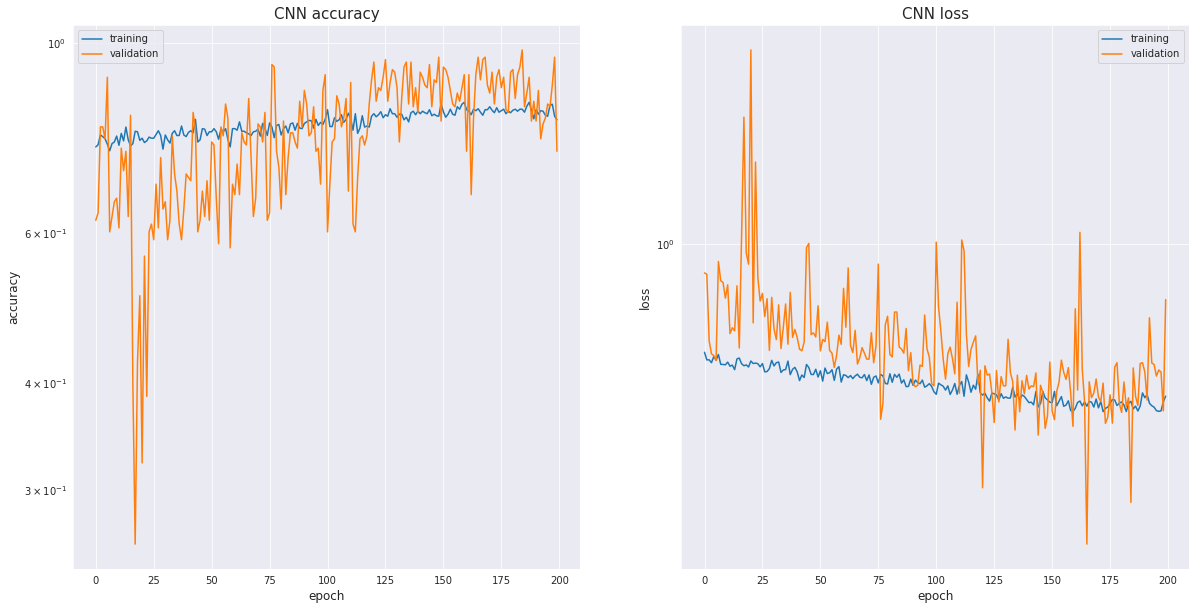

In [112]:
hist_cnn = pd.read_pickle('ckpts/trainHistoryCNN')

plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
plt.subplot(121)
plt.plot(hist_cnn['accuracy'])
plt.plot(hist_cnn['val_accuracy'])
plt.title('CNN accuracy', fontsize=15)
plt.ylabel('accuracy', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['training', 'validation'], loc='upper left')
plt.subplot(122)
plt.plot(hist_cnn['loss'])
plt.plot(hist_cnn['val_loss'])
plt.title('CNN loss', fontsize=15)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['training', 'validation'], loc='upper right')
plt.savefig("/home/giorgia/Desktop/MAI/Thesis/figures/CNN_training.png")


In [71]:
model.load_weights("ckpts/cnn_166.h5")
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
pred_probs_cnn, pred_class_xìcnn = get_preditictions(model, test_data)

              precision    recall  f1-score   support

         0.0       0.69      0.98      0.81        87
         1.0       0.96      0.56      0.71        88

    accuracy                           0.77       175
   macro avg       0.82      0.77      0.76       175
weighted avg       0.82      0.77      0.76       175



## Transfer Learning

### Training Xception

In [72]:
# preprocess data 
inputs = keras.Input(shape = (256, 256, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1.0 / 255)(x)

# load pre-trained model and weights without last layer
x = Xception(weights=None, include_top=False, input_shape=(256, 256, 3))(x)

# add layers on top
#x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# final model to train
tf_model_xception = keras.Model(inputs, outputs)


In [9]:
epochs = 70
callbacks = [
    keras.callbacks.ModelCheckpoint("ckpts/tf_xception_{epoch}.h5", save_best_only=True),
]
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs',
                 histogram_freq=1, 
                 write_graph=True, 
                 write_images=False)

tf_model_xception.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
hist_xception = tf_model_xception.fit(
    x =np.array(training_data), y=np.array(training_labels), epochs=epochs, callbacks=[callbacks, tensorboard], validation_split = .15, batch_size=32
)

# save history 
with open('ckpts/trainHistoryXception', 'wb') as file_pi:
    pickle.dump(hist_xception.history, file_pi)

Epoch 1/70
27/27 [==============================] - 278s 10s/step - loss: 0.6035 - accuracy: 0.7305 - val_loss: 0.7269 - val_accuracy: 0.0000e+00
Epoch 2/70
27/27 [==============================] - 274s 10s/step - loss: 0.4598 - accuracy: 0.7818 - val_loss: 0.7323 - val_accuracy: 0.0000e+00
Epoch 3/70
27/27 [==============================] - 285s 11s/step - loss: 0.4766 - accuracy: 0.7865 - val_loss: 0.7084 - val_accuracy: 0.0000e+00
Epoch 4/70
27/27 [==============================] - 272s 10s/step - loss: 0.4337 - accuracy: 0.8145 - val_loss: 0.7234 - val_accuracy: 0.0000e+00
Epoch 5/70
27/27 [==============================] - 265s 10s/step - loss: 0.4252 - accuracy: 0.7946 - val_loss: 0.7281 - val_accuracy: 0.0000e+00
Epoch 6/70
27/27 [==============================] - 264s 10s/step - loss: 0.3970 - accuracy: 0.8261 - val_loss: 0.7283 - val_accuracy: 0.0000e+00
Epoch 7/70
27/27 [==============================] - 264s 10s/step - loss: 0.3881 - accuracy: 0.8343 - val_loss: 0.7343 - val

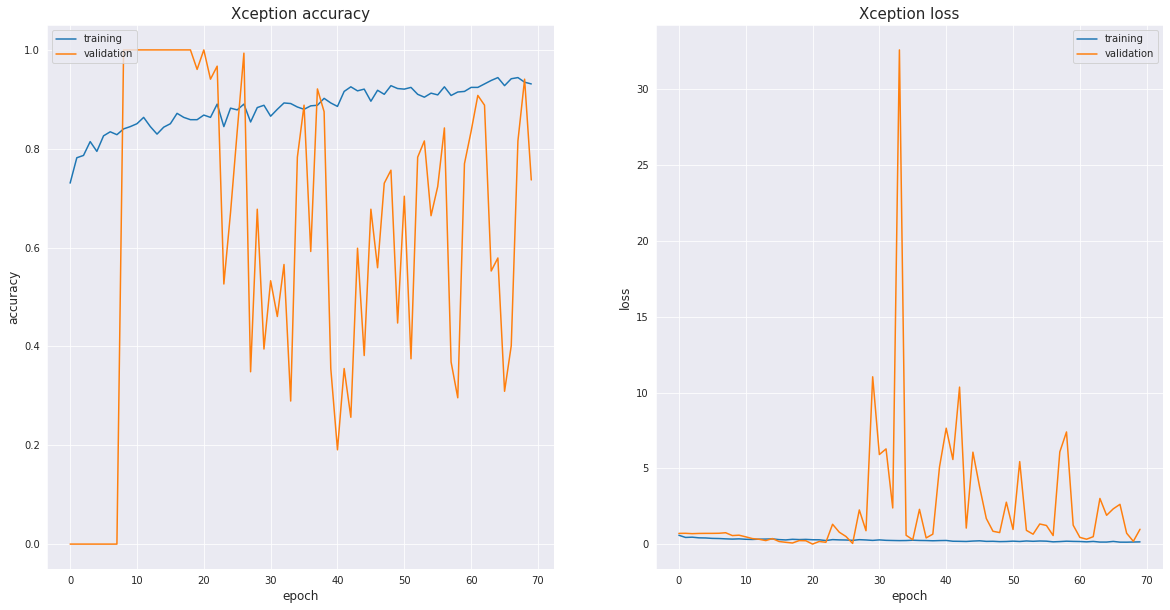

In [14]:
hist_xception = pd.read_pickle('ckpts/trainHistoryXception')

plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
plt.subplot(121)
plt.plot(hist_xception['accuracy'])
plt.plot(hist_xception['val_accuracy'])
plt.title('Xception accuracy', fontsize=15)
plt.ylabel('accuracy',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['training', 'validation'], loc='upper left')
plt.subplot(122)
plt.plot(hist_xception['loss'])
plt.plot(hist_xception['val_loss'])
plt.title('Xception loss', fontsize=15)
plt.ylabel('loss',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['training', 'validation'], loc='upper right')
plt.savefig("/home/giorgia/Desktop/MAI/Thesis/figures/Xception_training.png")

In [73]:
# load weights of trained model and compile 
tf_model_xception.load_weights("ckpts/tf_xception_21.h5")
tf_model_xception.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
pred_probs_x, pred_class_x = get_preditictions(tf_model_xception, test_data)

              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75        87
         1.0       1.00      0.35      0.52        88

    accuracy                           0.67       175
   macro avg       0.80      0.68      0.64       175
weighted avg       0.80      0.67      0.64       175



### Training EfficientNetB0

In [74]:
from skimage.transform import resize

img_size = 224
training_data_eff = [resize(im, [img_size, img_size, 3]) for im in training_data]
test_data_eff = [resize(im, [img_size, img_size, 3]) for im in test_data]

In [75]:
# preprocess data 
inputs = keras.Input(shape = (img_size, img_size, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1.0 / 255)(x)

# load pre-trained model and weights without last layer
x = EfficientNetB0(weights=None, include_top=False, input_shape=(img_size, img_size, 3), drop_connect_rate= 0.1)(x) #parameter serves as a toggle for extra regularization in finetuning

# add layers on top
#x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# final model to train
tf_model_eff = keras.Model(inputs, outputs)

In [9]:
epochs = 70
callbacks = [
    keras.callbacks.ModelCheckpoint("ckpts/tf_effnetb0_{epoch}.h5", save_best_only=True),
]
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs',
                 histogram_freq=1, 
                 write_graph=True, 
                 write_images=False)

tf_model_eff.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
hist_effnet = tf_model_eff.fit(
    x =np.array(training_data_eff), y=np.array(training_labels), epochs=epochs, callbacks=[callbacks, tensorboard], validation_split = .15, batch_size=32
)

# save history
with open('ckpts/trainHistoryEffNetB0', 'wb') as file_pi:
    pickle.dump(hist_effnet.history, file_pi)

Epoch 1/70
28/28 [==============================] - 104s 3s/step - loss: 0.5941 - accuracy: 0.6586 - val_loss: 0.5276 - val_accuracy: 1.0000
Epoch 2/70
28/28 [==============================] - 91s 3s/step - loss: 0.5132 - accuracy: 0.7382 - val_loss: 0.4472 - val_accuracy: 1.0000
Epoch 3/70
28/28 [==============================] - 91s 3s/step - loss: 0.4854 - accuracy: 0.7624 - val_loss: 0.1976 - val_accuracy: 1.0000
Epoch 4/70
28/28 [==============================] - 88s 3s/step - loss: 0.4946 - accuracy: 0.7405 - val_loss: 0.2865 - val_accuracy: 1.0000
Epoch 5/70
28/28 [==============================] - 88s 3s/step - loss: 0.4765 - accuracy: 0.7624 - val_loss: 0.1469 - val_accuracy: 1.0000
Epoch 6/70
28/28 [==============================] - 87s 3s/step - loss: 0.4353 - accuracy: 0.7785 - val_loss: 0.0116 - val_accuracy: 1.0000
Epoch 7/70
28/28 [==============================] - 87s 3s/step - loss: 0.5170 - accuracy: 0.7474 - val_loss: 0.1423 - val_accuracy: 1.0000
Epoch 8/70
28/28 [=

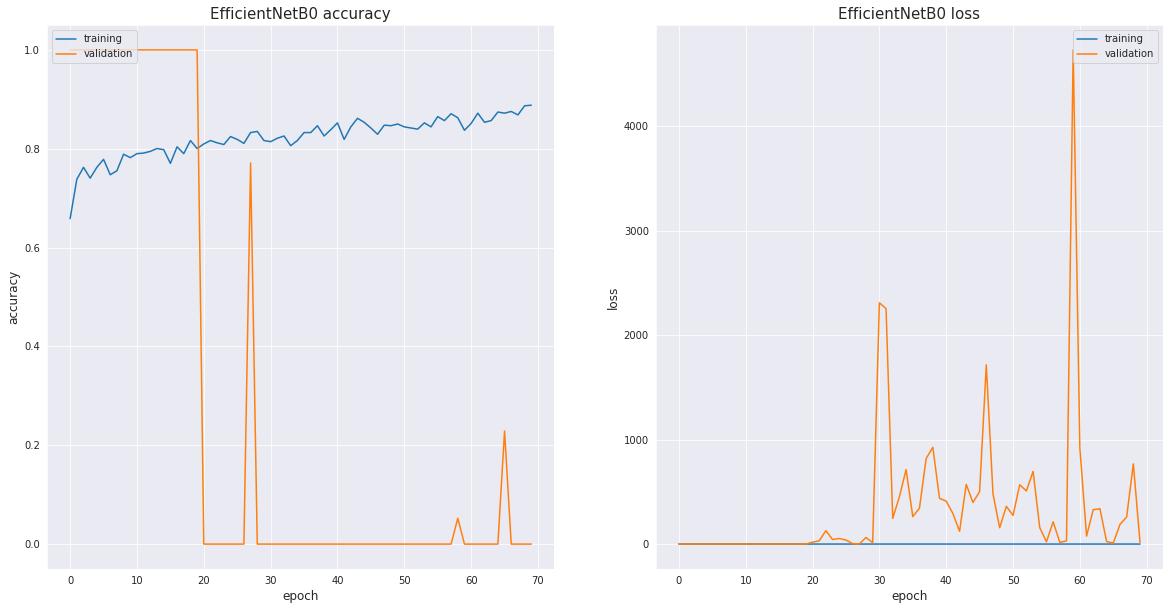

In [20]:
hist_effnet = pd.read_pickle('ckpts/trainHistoryEffNetB0')

plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
plt.subplot(121)
plt.plot(hist_effnet['accuracy']) # or hist_effnet.history["accuracy"] if history is already in a variable and not read from file
plt.plot(hist_effnet['val_accuracy'])
plt.title('EfficientNetB0 accuracy', fontsize=15)
plt.ylabel('accuracy', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['training', 'validation'], loc='upper left')
plt.subplot(122)
plt.plot(hist_effnet['loss'])
plt.plot(hist_effnet['val_loss'])
plt.title('EfficientNetB0 loss', fontsize=15)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['training', 'validation'], loc='upper right')
plt.savefig("/home/giorgia/Desktop/MAI/Thesis/figures/EfficientNetB0_training.png")

In [76]:

tf_model_eff.load_weights("ckpts/tf_effnetb0_17.h5")
tf_model_eff.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
pred_probs_eff, pred_class_eff = get_preditictions(tf_model_eff, test_data_eff)

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.66        87
         1.0       0.00      0.00      0.00        88

    accuracy                           0.50       175
   macro avg       0.25      0.50      0.33       175
weighted avg       0.25      0.50      0.33       175



/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### CNN + Random Forest 

In [78]:
final_layer = "global_average_pooling2d"
extractor = keras.Model(inputs=model.input,
                        outputs=model.get_layer(final_layer).output)
features = extractor(np.array(training_data))

rfcnn = RandomForestClassifier(n_estimators=10, max_features=10)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfcnn_random = RandomizedSearchCV(estimator = rfcnn, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1) #verbose=2, 
# Fit the random search model
rfcnn_random.fit(np.array(features), training_labels)

best_rfcnn = rfcnn_random.best_estimator_
best_rfcnn.fit(np.array(features), training_labels)

features_test = np.array(extractor(np.array(test_data)))
pred_probs_rfcnn = best_rfcnn.predict_proba(features_test)[:, 1]
accuracy_score(test_labels, best_rfcnn.predict(features_test))
print(classification_report(test_labels,  best_rfcnn.predict(features_test)))

2022-02-24 09:36:38.181091: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 773062656 exceeds 10% of free system memory.
2022-02-24 09:36:38.300398: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 773062656 exceeds 10% of free system memory.
2022-02-24 09:36:38.390475: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 773062656 exceeds 10% of free system memory.
2022-02-24 09:36:38.545473: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1030750208 exceeds 10% of free system memory.
2022-02-24 09:36:39.143761: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1030750208 exceeds 10% of free system memory.


              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83        87
         1.0       0.85      0.80      0.82        88

    accuracy                           0.83       175
   macro avg       0.83      0.83      0.83       175
weighted avg       0.83      0.83      0.83       175



/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/giorgia/Desktop/MAI/Thesis/litter_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keywor

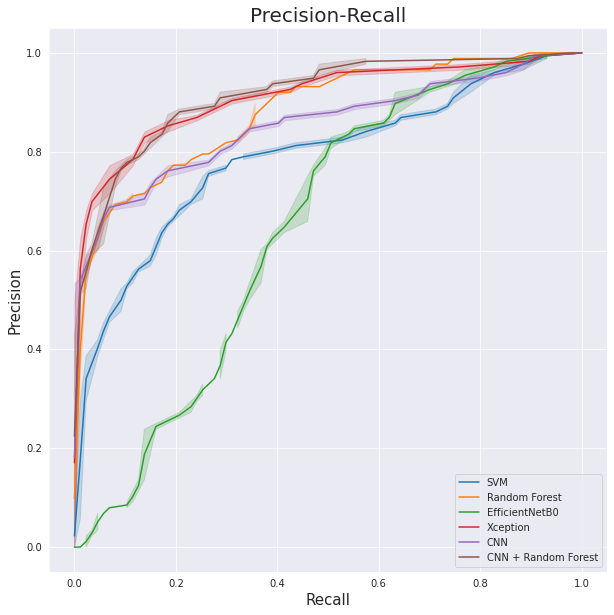

In [88]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, plot_roc_curve

import seaborn as sns 

plt.figure(figsize=(10,10))
plt.title("Precision-Recall", fontsize=20)

sns.set_style("darkgrid")
# SVM
fpr, tpr, thresholds = roc_curve(test_labels_, pred_probs_svm)
sns.lineplot(fpr, tpr, label="SVM")

sns.set_style("darkgrid")
# RF
fpr, tpr, thresholds = roc_curve(test_labels_, pred_probs_rf)
sns.lineplot(fpr, tpr, label="Random Forest")

sns.set_style("darkgrid")
# EffNet
fpr, tpr, thresholds = roc_curve(test_labels, pred_probs_eff)
sns.lineplot(fpr, tpr, label="EfficientNetB0")

sns.set_style("darkgrid")
# Xception
fpr, tpr, thresholds = roc_curve(test_labels, pred_probs_x)
sns.lineplot(fpr, tpr, label="Xception")
plt.legend()

sns.set_style("darkgrid")
# CNN
fpr, tpr, thresholds = roc_curve(test_labels, pred_probs_cnn)
sns.lineplot(fpr, tpr, label="CNN")

sns.set_style("darkgrid")
# CNN + Random Forest
fpr, tpr, thresholds = roc_curve(test_labels, pred_probs_rfcnn)
sns.lineplot(fpr, tpr, label="CNN + Random Forest")
plt.legend()


plt.ylabel("Precision", fontsize=15)
plt.xlabel("Recall", fontsize=15)
plt.savefig("/home/giorgia/Desktop/MAI/Thesis/figures/ROC_CNN_EffNetB0_Xception.png")